In [1]:
# ============================================================================
# CELL 1: Initialize Spark Session
# ============================================================================
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, trim, regexp_replace, when, isnan
from pyspark.sql.types import DoubleType
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create Spark session
spark = SparkSession.builder \
    .appName("NetworkAttackDetection") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "8") \
    .getOrCreate()

print(f"✓ Spark Version: {spark.version}")
print(f"✓ Spark UI available at: http://localhost:4040")
print(f"✓ Spark Session created successfully!")

✓ Spark Version: 3.5.0
✓ Spark UI available at: http://localhost:4040
✓ Spark Session created successfully!


In [2]:
# ============================================================================
# CELL 2: Load Dataset with Spark
# ============================================================================
# Load CSV file
df_spark = spark.read.csv(
    'MachineLearningCVE/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv',
    header=True,
    inferSchema=True
)

print(f"Dataset loaded!")
print(f"Total rows: {df_spark.count():,}")
print(f"Total columns: {len(df_spark.columns)}")
print(f"\nSchema info:")
df_spark.printSchema()

Dataset loaded!
Total rows: 170,366
Total columns: 79

Schema info:
root
 |--  Destination Port: integer (nullable = true)
 |--  Flow Duration: integer (nullable = true)
 |--  Total Fwd Packets: integer (nullable = true)
 |--  Total Backward Packets: integer (nullable = true)
 |-- Total Length of Fwd Packets: integer (nullable = true)
 |--  Total Length of Bwd Packets: integer (nullable = true)
 |--  Fwd Packet Length Max: integer (nullable = true)
 |--  Fwd Packet Length Min: integer (nullable = true)
 |--  Fwd Packet Length Mean: double (nullable = true)
 |--  Fwd Packet Length Std: double (nullable = true)
 |-- Bwd Packet Length Max: integer (nullable = true)
 |--  Bwd Packet Length Min: integer (nullable = true)
 |--  Bwd Packet Length Mean: double (nullable = true)
 |--  Bwd Packet Length Std: double (nullable = true)
 |-- Flow Bytes/s: double (nullable = true)
 |--  Flow Packets/s: double (nullable = true)
 |--  Flow IAT Mean: double (nullable = true)
 |--  Flow IAT Std: double (

In [3]:
# ============================================================================
# CELL 3: Clean Column Names
# ============================================================================
# Remove leading/trailing spaces from column names
old_columns = df_spark.columns
new_columns = [col_name.strip() for col_name in old_columns]

# Rename columns
for old_col, new_col in zip(old_columns, new_columns):
    if old_col != new_col:
        df_spark = df_spark.withColumnRenamed(old_col, new_col)

print("✓ Column names cleaned")
print(f"\nSample column names:")
print(df_spark.columns[:5])

✓ Column names cleaned

Sample column names:
['Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets']


First 5 rows:
+----------------+-------------+-----------------+----------------------+---------------------------+---------------------------+---------------------+---------------------+----------------------+---------------------+---------------------+---------------------+----------------------+---------------------+------------+--------------+-------------+------------+------------+------------+-------------+------------+-----------+-----------+-----------+-------------+------------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+-------------------+-----------------+-------------+-------------+-----------------+-----------------+------------------+-----------------+----------------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+-------------+-------------------+--------------------+--------------------+-------------------+------------------+-------------------

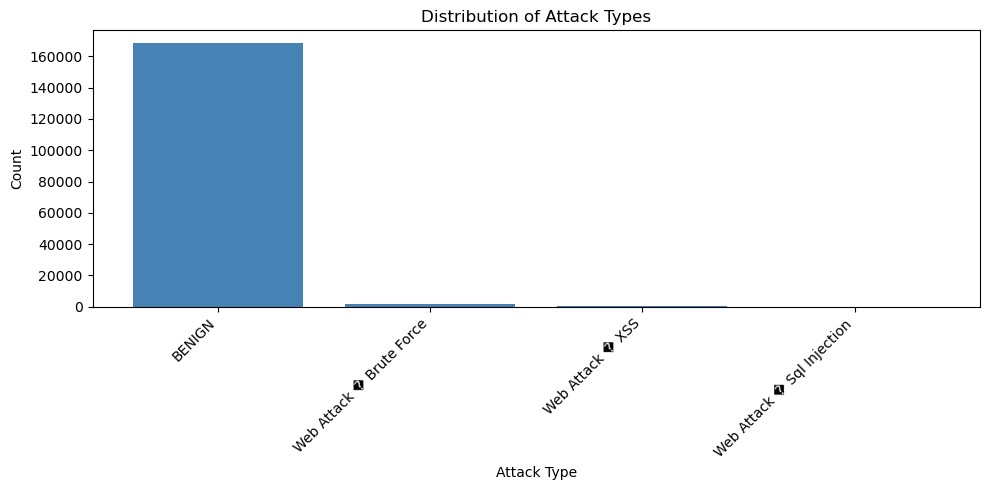

In [4]:

# ============================================================================
# CELL 4: Explore Target Variable (Labels)
# ============================================================================
# Show first few rows
print("First 5 rows:")
df_spark.show(5, truncate=False)

# Count label distribution
print("\n" + "="*60)
print("Label Distribution:")
print("="*60)
label_counts = df_spark.groupBy("Label").count().orderBy(col("count").desc())
label_counts.show(truncate=False)

# Convert to pandas for visualization
label_counts_pd = label_counts.toPandas()

# Calculate percentages
total = label_counts_pd['count'].sum()
label_counts_pd['percentage'] = (label_counts_pd['count'] / total * 100).round(2)
print("\nLabel Distribution (%):")
print(label_counts_pd)

# Visualize
plt.figure(figsize=(10, 5))
plt.bar(label_counts_pd['Label'], label_counts_pd['count'], color='steelblue')
plt.title('Distribution of Attack Types')
plt.xlabel('Attack Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [5]:
# ============================================================================
# CELL 5: Data Cleaning
# ============================================================================
print("Starting data cleaning...")

# 1. Clean label names (fix encoding issues)
df_spark = df_spark.withColumn(
    "Label",
    trim(regexp_replace(col("Label"), "�", "-"))
)

print("\n✓ Labels cleaned")
print("Updated label distribution:")
df_spark.groupBy("Label").count().orderBy(col("count").desc()).show(truncate=False)

# 2. Check for missing values
print("\n" + "="*60)
print("Checking for missing values...")
print("="*60)

# Count nulls per column
null_counts = df_spark.select([
    count(when(col(c).isNull(), c)).alias(c) 
    for c in df_spark.columns
])

# Convert to pandas for easier viewing
null_counts_pd = null_counts.toPandas().T
null_counts_pd.columns = ['null_count']
null_counts_pd = null_counts_pd[null_counts_pd['null_count'] > 0]

if len(null_counts_pd) > 0:
    print("Columns with missing values:")
    print(null_counts_pd)
    
    # Drop rows with any null values
    rows_before = df_spark.count()
    df_spark = df_spark.dropna()
    rows_after = df_spark.count()
    print(f"\nRows before: {rows_before:,}")
    print(f"Rows after: {rows_after:,}")
    print(f"Rows dropped: {rows_before - rows_after:,}")
else:
    print("✓ No missing values found")

# 3. Handle infinity values
print("\n" + "="*60)
print("Checking for infinity values...")
print("="*60)

# Get numeric columns
numeric_cols = [field.name for field in df_spark.schema.fields 
                if str(field.dataType) in ['DoubleType', 'FloatType', 'DoubleType()']]

# Replace infinity with null, then fill with median
for col_name in numeric_cols:
    if col_name != 'Label':
        # Check if column has infinity
        inf_count = df_spark.filter(
            (col(col_name) == float('inf')) | (col(col_name) == float('-inf'))
        ).count()
        
        if inf_count > 0:
            print(f"  {col_name}: {inf_count} infinite values")
            
            # Calculate median
            median_val = df_spark.approxQuantile(col_name, [0.5], 0.01)[0]
            
            # Replace infinity with null, then fill with median
            df_spark = df_spark.withColumn(
                col_name,
                when(
                    (col(col_name) == float('inf')) | (col(col_name) == float('-inf')),
                    median_val
                ).otherwise(col(col_name))
            )

print("\n✓ Data cleaning complete!")
print(f"Final dataset shape: {df_spark.count():,} rows × {len(df_spark.columns)} columns")


Starting data cleaning...

✓ Labels cleaned
Updated label distribution:
+--------------------------+------+
|Label                     |count |
+--------------------------+------+
|BENIGN                    |168186|
|Web Attack - Brute Force  |1507  |
|Web Attack - XSS          |652   |
|Web Attack - Sql Injection|21    |
+--------------------------+------+


Checking for missing values...
✓ No missing values found

Checking for infinity values...
  Flow Bytes/s: 115 infinite values
  Flow Packets/s: 135 infinite values

✓ Data cleaning complete!
Final dataset shape: 170,366 rows × 79 columns


In [6]:
# ============================================================================
# CELL 6: Prepare Data for ML with MLlib
# ============================================================================
from pyspark.sql.functions import when, col
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler

# Replace 'df_cleaned' with your actual cleaned DataFrame variable
df_input = df_spark

# 1. Handle infinite values by replacing them with nulls
numeric_cols = [c for c, t in df_input.dtypes if t in ('int', 'double')]
for c in numeric_cols:
    df_input = df_input.withColumn(c, when(col(c).isin([float('inf'), float('-inf')]), None).otherwise(col(c)))

# 2. Drop rows with nulls in numeric columns
df_input = df_input.dropna(subset=numeric_cols)

# 3. Label encoding
label_indexer = StringIndexer(inputCol="Label", outputCol="label_indexed")
df_input = label_indexer.fit(df_input).transform(df_input)

print("Label Encoding:")
df_input.select("Label", "label_indexed").distinct().show()

# 4. Assemble numeric features
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features_raw")
df_assembled = assembler.transform(df_input)

print(f"Number of numeric features: {len(numeric_cols)}")

# 5. Scale features
scaler = StandardScaler(inputCol="features_raw", outputCol="features")
scaler_model = scaler.fit(df_assembled)
df_scaled = scaler_model.transform(df_assembled)

# 6. Select final dataset with scaled features and label
df_final = df_scaled.select("features", "label_indexed")

print("✓ Data prepared for machine learning!")
df_final.show(5, truncate=False)


Label Encoding:
+--------------------+-------------+
|               Label|label_indexed|
+--------------------+-------------+
|              BENIGN|          0.0|
|Web Attack - Brut...|          1.0|
|Web Attack - Sql ...|          3.0|
|    Web Attack - XSS|          2.0|
+--------------------+-------------+

Number of numeric features: 78
✓ Data prepared for machine learning!
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [7]:
# ============================================================================
# CELL 7: Split Train/Test Sets
# ============================================================================
# Split 80-20
train_data, test_data = df_final.randomSplit([0.8, 0.2], seed=42)

print(f"Training set: {train_data.count():,} samples")
print(f"Test set: {test_data.count():,} samples")

# Cache for faster access
train_data.cache()
test_data.cache()

print("\n✓ Train/test split complete!")

Training set: 136,475 samples
Test set: 33,871 samples

✓ Train/test split complete!


In [13]:
# ============================================================================
# CELL 8: Train Model 1 - Logistic Regression
# ============================================================================
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

print("Training Logistic Regression...")

# Train model
lr = LogisticRegression(
    featuresCol="features",
    labelCol="label_indexed",
    maxIter=100,
    regParam=0.01
)

lr_model = lr.fit(train_data)

# Make predictions
lr_predictions = lr_model.transform(test_data)

# Evaluate
evaluator_accuracy = MulticlassClassificationEvaluator(
    labelCol="label_indexed",
    predictionCol="prediction",
    metricName="accuracy"
)

evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="label_indexed",
    predictionCol="prediction",
    metricName="f1"
)

lr_accuracy = evaluator_accuracy.evaluate(lr_predictions)
lr_f1 = evaluator_f1.evaluate(lr_predictions)

print("\n" + "="*60)
print("LOGISTIC REGRESSION RESULTS")
print("="*60)
print(f"Accuracy: {lr_accuracy:.4f}")
print(f"F1-Score: {lr_f1:.4f}")

# Confusion matrix
print("\nConfusion Matrix:")
lr_predictions.groupBy("label_indexed", "prediction").count().show()

Training Logistic Regression...

LOGISTIC REGRESSION RESULTS
Accuracy: 0.9866
F1-Score: 0.9807

Confusion Matrix:
+-------------+----------+-----+
|label_indexed|prediction|count|
+-------------+----------+-----+
|          0.0|       1.0|   29|
|          0.0|       0.0|33416|
|          1.0|       0.0|  280|
|          2.0|       0.0|  143|
|          3.0|       0.0|    3|
+-------------+----------+-----+



In [14]:
# ============================================================================
# CELL 9: Train Model 2 - Decision Tree
# ============================================================================
from pyspark.ml.classification import DecisionTreeClassifier

print("Training Decision Tree...")

# Train model
dt = DecisionTreeClassifier(
    featuresCol="features",
    labelCol="label_indexed",
    maxDepth=10,
    seed=42
)

dt_model = dt.fit(train_data)

# Make predictions
dt_predictions = dt_model.transform(test_data)

# Evaluate
dt_accuracy = evaluator_accuracy.evaluate(dt_predictions)
dt_f1 = evaluator_f1.evaluate(dt_predictions)

print("\n" + "="*60)
print("DECISION TREE RESULTS")
print("="*60)
print(f"Accuracy: {dt_accuracy:.4f}")
print(f"F1-Score: {dt_f1:.4f}")

# Confusion matrix
print("\nConfusion Matrix:")
dt_predictions.groupBy("label_indexed", "prediction").count().show()

Training Decision Tree...

DECISION TREE RESULTS
Accuracy: 0.9955
F1-Score: 0.9941

Confusion Matrix:
+-------------+----------+-----+
|label_indexed|prediction|count|
+-------------+----------+-----+
|          0.0|       3.0|    1|
|          1.0|       2.0|    3|
|          0.0|       0.0|33439|
|          1.0|       1.0|  275|
|          1.0|       0.0|    2|
|          0.0|       2.0|    4|
|          3.0|       1.0|    2|
|          0.0|       1.0|    1|
|          2.0|       0.0|    1|
|          2.0|       1.0|  137|
|          2.0|       2.0|    5|
|          3.0|       0.0|    1|
+-------------+----------+-----+



In [8]:
# ============================================================================
# CELL 10: Train Model 3 - Random Forest (fixed)
# ============================================================================
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

print("Training Random Forest...")

# Define evaluators (you forgot these earlier)
evaluator_accuracy = MulticlassClassificationEvaluator(
    labelCol="label_indexed",
    predictionCol="prediction",
    metricName="accuracy"
)

evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="label_indexed",
    predictionCol="prediction",
    metricName="f1"
)

# Train model
rf = RandomForestClassifier(
    featuresCol="features",
    labelCol="label_indexed",
    numTrees=100,
    maxDepth=15,
    seed=42
)

rf_model = rf.fit(train_data)

# Make predictions
rf_predictions = rf_model.transform(test_data)

# Evaluate
rf_accuracy = evaluator_accuracy.evaluate(rf_predictions)
rf_f1 = evaluator_f1.evaluate(rf_predictions)

print("\n" + "="*60)
print("RANDOM FOREST RESULTS")
print("="*60)
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"F1-Score: {rf_f1:.4f}")

# Confusion matrix
print("\nConfusion Matrix:")
rf_predictions.groupBy("label_indexed", "prediction").count().show()


Training Random Forest...

RANDOM FOREST RESULTS
Accuracy: 0.9957
F1-Score: 0.9942

Confusion Matrix:
+-------------+----------+-----+
|label_indexed|prediction|count|
+-------------+----------+-----+
|          0.0|       0.0|33445|
|          1.0|       1.0|  278|
|          1.0|       0.0|    2|
|          2.0|       0.0|    3|
|          2.0|       1.0|  137|
|          2.0|       2.0|    3|
|          3.0|       0.0|    2|
|          3.0|       3.0|    1|
+-------------+----------+-----+




MODEL COMPARISON
              Model  Accuracy  F1-Score
Logistic Regression  0.986567  0.980746
      Decision Tree  0.995512  0.994090
      Random Forest  0.995749  0.994151


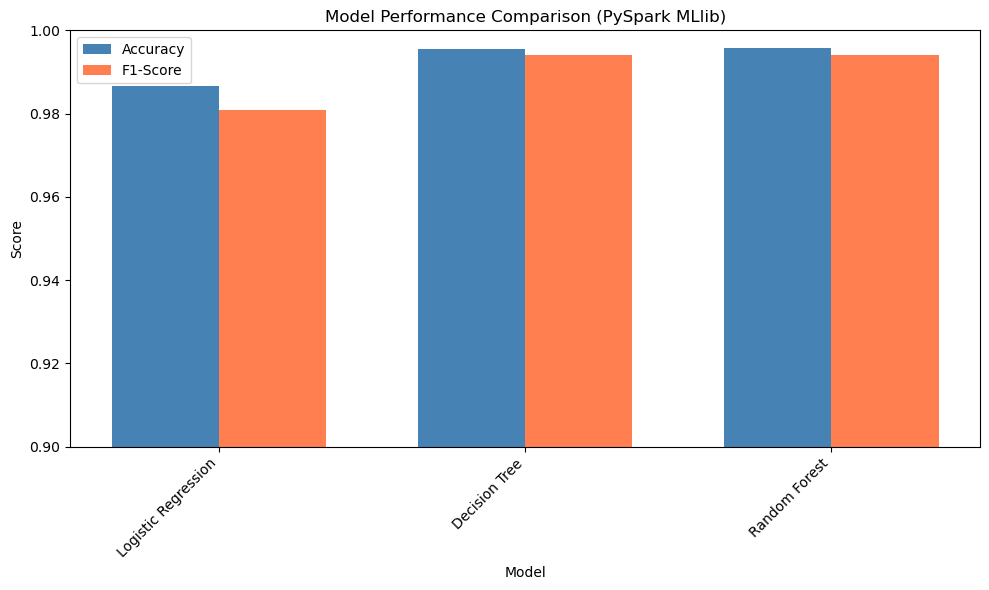

In [16]:

# ============================================================================
# CELL 11: Compare All Models
# ============================================================================
import pandas as pd

# Create comparison dataframe
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest'],
    'Accuracy': [lr_accuracy, dt_accuracy, rf_accuracy],
    'F1-Score': [lr_f1, dt_f1, rf_f1]
})

print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)
print(results.to_string(index=False))

# Visualize comparison
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
x = range(len(results))
width = 0.35

bars1 = ax.bar([i - width/2 for i in x], results['Accuracy'], width, label='Accuracy', color='steelblue')
bars2 = ax.bar([i + width/2 for i in x], results['F1-Score'], width, label='F1-Score', color='coral')

ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison (PySpark MLlib)')
ax.set_xticks(x)
ax.set_xticklabels(results['Model'], rotation=45, ha='right')
ax.legend()
ax.set_ylim(0.9, 1.0)

plt.tight_layout()
plt.show()


Top 20 Most Important Features:
                feature  importance
            Fwd IAT Min    0.123449
           Flow IAT Min    0.083857
    Fwd Header Length55    0.049991
Init_Win_bytes_backward    0.046251
           Flow IAT Std    0.043051
      Max Packet Length    0.042950
    Fwd Header Length34    0.042873
            Fwd IAT Std    0.038375
       Destination Port    0.034245
           Flow Bytes/s    0.033803
     Packet Length Mean    0.032213
         PSH Flag Count    0.027657
           Flow IAT Max    0.025138
         Flow Packets/s    0.023733
           Fwd IAT Mean    0.022755
    Average Packet Size    0.021341
  Fwd Packet Length Max    0.021100
          Fwd IAT Total    0.020626
          Flow IAT Mean    0.019556
          Bwd Packets/s    0.019549


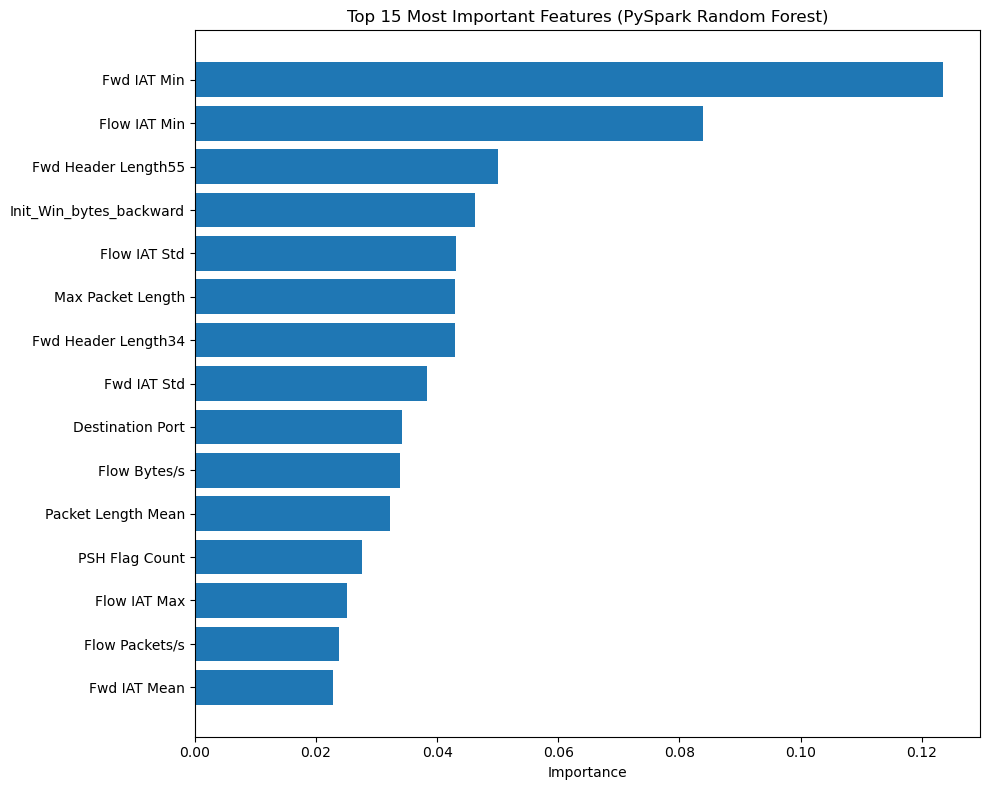

In [9]:
# ============================================================================
# CELL 12: Feature Importance (Random Forest) — FINAL FIXED
# ============================================================================

# Ensure assembler exists
if 'assembler' not in dir():
    raise ValueError("The VectorAssembler variable 'assembler' is missing. Run the cell where you created it.")

# Correct feature order from assembler
feature_cols = assembler.getInputCols()

# Extract importances
importances = rf_model.featureImportances.toArray()

# Build DataFrame
feature_importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': importances
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(feature_importance_df.head(20).to_string(index=False))

# Plot top 15
plt.figure(figsize=(10, 8))
top_features = feature_importance_df.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 15 Most Important Features (PySpark Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()



Preparing confusion matrix...


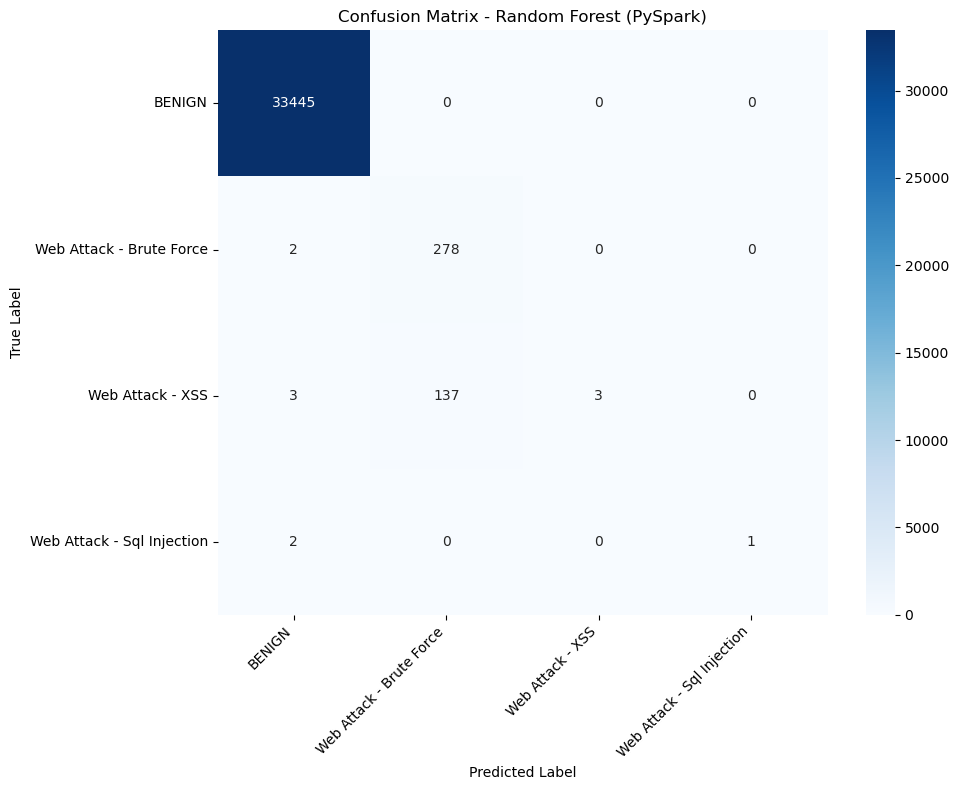

In [10]:
# ============================================================================
# CELL 13: Confusion Matrix — FINAL FIX
# ============================================================================

from sklearn.metrics import confusion_matrix

print("Preparing confusion matrix...")

# 1. Convert predictions to pandas
pred_and_labels = rf_predictions.select("prediction", "label_indexed").toPandas()

y_true = pred_and_labels["label_indexed"].astype(int)
y_pred = pred_and_labels["prediction"].astype(int)

# 2. Build confusion matrix
cm = confusion_matrix(y_true, y_pred)

# 3. Get label names from the actual StringIndexerModel
label_names = label_indexer.fit(df_spark).labels

# 4. Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names,
            yticklabels=label_names)
plt.title("Confusion Matrix - Random Forest (PySpark)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



In [11]:
# ============================================================================
# CELL: Save PySpark Models (Deployment-Ready)
# ============================================================================

import os
from datetime import datetime
import json

# Create models directory
os.makedirs('work/models_spark', exist_ok=True)

# -----------------------------
# 1️⃣ Save Random Forest model
# -----------------------------
model_path = 'work/models_spark/random_forest_model'
rf_model.write().overwrite().save(model_path)
print(f"✓ Random Forest model saved: {model_path}")

# -----------------------------
# 2️⃣ Save preprocessing steps
# -----------------------------
# DO NOT SAVE VectorAssembler. It's stateless and not serializable.
# Recreate it during deployment using the same feature list.

# Save StandardScaler model
scaler_path = 'work/models_spark/scaler'
scaler_model.write().overwrite().save(scaler_path)
print(f"✓ StandardScaler saved: {scaler_path}")

# Save label indexer model
label_indexer_path = 'work/models_spark/label_indexer'
label_indexer_model = label_indexer.fit(df_spark)
label_indexer_model.write().overwrite().save(label_indexer_path)
print(f"✓ Label Indexer saved: {label_indexer_path}")

# -----------------------------
# 3️⃣ Save metadata for deployment
# -----------------------------
metadata = {
    'model_type': 'RandomForestClassifier',
    'accuracy': rf_accuracy if 'rf_accuracy' in locals() else None,
    'f1_score': rf_f1 if 'rf_f1' in locals() else None,
    'n_features': len(feature_cols),
    'feature_names': feature_cols,
    'training_date': datetime.now().isoformat(),
    'spark_version': spark.version,
    'dataset': 'CICIDS2017-Thursday-Morning-WebAttacks'
}

with open('work/models_spark/metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"✓ Metadata saved: work/models_spark/metadata.json")

print("\n" + "="*60)
print("All PySpark model artifacts saved and ready for deployment!")
print("="*60)


✓ Random Forest model saved: work/models_spark/random_forest_model
✓ StandardScaler saved: work/models_spark/scaler
✓ Label Indexer saved: work/models_spark/label_indexer
✓ Metadata saved: work/models_spark/metadata.json

All PySpark model artifacts saved and ready for deployment!


In [8]:
from pyspark.ml.classification import RandomForestClassificationModel
from pyspark.ml.feature import VectorAssembler, StandardScalerModel, StringIndexerModel

# -----------------------------
# 1️⃣ Load preprocessing models
# -----------------------------

assembler_loaded = VectorAssembler.load("work/models_spark/assembler")
scaler_loaded = StandardScalerModel.load("work/models_spark/scaler")
label_indexer_loaded = StringIndexerModel.load("work/models_spark/label_indexer")

# -----------------------------
# 2️⃣ Load the Random Forest model
# -----------------------------

rf_model_loaded = RandomForestClassificationModel.load(
    "work/models_spark/random_forest_model"
)

print("✓ All components loaded successfully!")

# -----------------------------
# 3️⃣ Rebuild the prediction pipeline
# -----------------------------

from pyspark.ml import Pipeline, PipelineModel

pipeline_loaded = Pipeline(stages=[
    assembler_loaded,
    scaler_loaded,
    rf_model_loaded
]).fit(df_spark)   # fit is required to initialize stages properly

print("✓ Pipeline rebuilt and ready to infer!")


✓ All components loaded successfully!
✓ Pipeline rebuilt and ready to infer!
